In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./')
sys.path.append('../')

In [3]:
%matplotlib widget
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual, fixed
import ipywidgets as widgets
from IPython.display import display

import sys
import os
import h5py
from matplotlib import pyplot as plt
import zarr
import numpy as np
from copy import deepcopy
from segmentation import *
import waterz



In [4]:
file = './data/anno_alice_T2030_tiny.zarr'
#file = 'anno_alice_T2030.zarr'
#file = '/mnt/d/thesis_data/abi-czi-file/Alice.zarr/'
a = zarr.open(file, 'a')
print(a.tree(level=2))

/
 ├── .zarr
 ├── Fragment_stats
 │   ├── Position
 │   ├── Volume
 │   └── id
 ├── Fragments (3, 15, 30, 30) uint64
 ├── Merge_tree
 │   ├── Merge
 │   └── Scoring
 ├── Raw (4, 3, 15, 30, 30) float64
 └── gt_trackimage (3, 15, 30, 30) uint64


In [6]:
print(a['Merge_tree/'].tree(level=2))
print(a['Merge_tree/Scoring/0'][1])

Merge_tree
 ├── Merge
 │   ├── 0 (596, 3) uint64
 │   ├── 1 (584, 3) uint64
 │   ├── 2 (610, 3) uint64
 │   ├── 3 (628, 3) uint64
 │   ├── 4 (620, 3) uint64
 │   ├── 5 (680, 3) uint64
 │   ├── 6 (658, 3) uint64
 │   ├── 7 (728, 3) uint64
 │   ├── 8 (705, 3) uint64
 │   └── 9 (667, 3) uint64
 └── Scoring
     ├── 0 (596,) float64
     ├── 1 (584,) float64
     ├── 2 (610,) float64
     ├── 3 (628,) float64
     ├── 4 (620,) float64
     ├── 5 (680,) float64
     ├── 6 (658,) float64
     ├── 7 (728,) float64
     ├── 8 (705,) float64
     └── 9 (667,) float64
0.005037069320678711


In [5]:
def draw_img(z, t):
    cmap = 'flag'
    fig = plt.figure(figsize=(10, 3))
      
    # setting values to rows and column variables
    rows = 1
    columns = 4
    fig.add_subplot(rows, columns, 1)

    # Plot segmented boundaries
    img = a['Raw'][3,t,:,:,:]
    plt.imshow(img[z], cmap='viridis')
    plt.axis('off')
    plt.title('Boundaries')

    # Assign unique values to GT fragments
    gt_img = a['gt_trackimage'][t, z, :, :].copy()
    for i,v in enumerate(np.unique(gt_img)):
        gt_img[gt_img == v] = i

    ## Plot
    fig.add_subplot(rows, columns, 2)
    plt.imshow(gt_img, cmap='viridis')
    plt.axis('off')
    plt.title('Groundtruth')

    # Extract fragments from image
    fragments = get_fragments_ws(img)

    ## Plot
    fig.add_subplot(rows, columns, 3)
    plt.imshow(fragments[z], cmap='flag')
    plt.axis('off')
    plt.title('Watershed')

    # Do waterz
    affs = get_affinities(img)
    thresholds = [0.5]
    
    gen = waterz.agglomerate(affs, thresholds, fragments=fragments,
                                 return_merge_history=True,
                                 return_region_graph=True)
    segs, graph, merges = next(gen)
    
    ## Plot
    fig.add_subplot(rows, columns, 4)
    plt.imshow(segs[z], cmap='flag')
    plt.axis('off')
    plt.title('WaterZ')
    plt.savefig('fragmentation.png')
    
    plt.show()

    return

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


_, max_t, max_z, *_ = a['Raw'].shape
p=interactive(draw_img, 
              z=widgets.IntSlider(min=0, max=max_z-1, step=1, continuous_update=True, value=0),
              t=widgets.IntSlider(min=0, max=max_t-1, step=1, continuous_update=True, value=0))
display(p)

interactive(children=(IntSlider(value=0, description='z', max=14), IntSlider(value=0, description='t', max=9),…

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 612 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2897
merging until threshold 0.5
computing initial scores
merging until 0.5
min edge score 0.00243843
threshold exceeded
merged 340 edges
extracting segmentation
merging until threshold 1
merging until 1
min edge score 0.500011
merged 389 edges
extracting segmentation
groundtruth: 214
watershed: 611
waterz1: 271
waterz2: 1


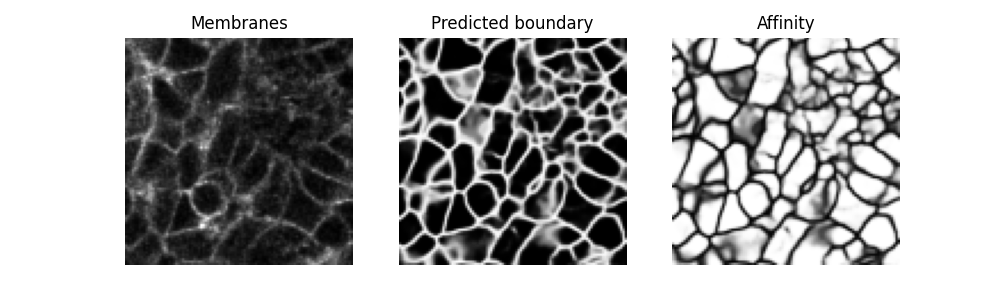

In [6]:
t = 2
z = 2
image = a['Raw'][3,t,:,:,:]
groundtruth = a['gt_trackimage'][t].copy()
for i,v in enumerate(np.unique(groundtruth)):
    groundtruth[groundtruth == v] = i
        
fragments = get_fragments_ws(image)
_fragments = fragments.copy()

affs = get_affinities(image)
thresholds = [0.5, 1]
gen = waterz.agglomerate(affs, thresholds, fragments=fragments,
                                 return_merge_history=True,
                                 return_region_graph=True)
segs, _, _ = next(gen)
wz = segs.copy()


segs, _, _ = next(gen)

print('groundtruth:', len(np.unique(groundtruth)))
print('watershed:', len(np.unique(_fragments)))
print('waterz1:', len(np.unique(wz)))
print('waterz2:', len(np.unique(segs)))


# Make sure labels stay the same with waterz
from skimage.measure import regionprops
import hashlib

for i, (c, r, l) in enumerate(sorted([(r.centroid, r, l) for l, r in zip(np.unique(wz), regionprops(wz))], key=lambda m: m[0])):
    #print(l, i, c)
    #wz[wz == l] = i
    pass


# display affinity
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(a['Raw'][0,t,z,:,:], cmap='gray')
plt.axis('off')
plt.title('Membranes')

fig.add_subplot(rows, columns, 2)
plt.imshow(image[z], cmap='gray')
plt.axis('off')
plt.title('Predicted boundary')

fig.add_subplot(rows, columns, 3)
plt.imshow(affs[0,z], cmap='gray')
plt.axis('off')
plt.title('Affinity')
plt.savefig('affinity.png')
plt.show()

In [7]:
gt_rp = regionprops(groundtruth)
wz_rp = regionprops(wz)

def draw_img(z):
    fig = plt.figure(figsize=(10, 3))
      
    # setting values to rows and column variables
    rows = 1
    columns = 5
    fig.add_subplot(rows, columns, 1)
    
    # Plot segmented boundaries
    plt.imshow(image[z], cmap='viridis')
    plt.axis('off')
    plt.title('Boundaries')
    
    # Assign unique values to GT fragments
    #gt_img = deepcopy(a['gt_trackimage'][t, z, :, :])
    #for i,v in enumerate(np.unique(gt_img)):
    #    gt_img[gt_img == v] = i
    
    ## Plot
    ax = fig.add_subplot(rows, columns, 2)
    plt.imshow(groundtruth[z])
    plt.axis('off')
    plt.title('GT')
    
    ## Plot
    fig.add_subplot(rows, columns, 3)
    plt.imshow(_fragments[z])
    plt.axis('off')
    plt.title('Watershed')
    
    # Plot
    fig.add_subplot(rows, columns, 4)
    plt.imshow(wz[z])
    plt.axis('off')
    plt.title('WaterZ1')
    
    # Plot
    fig.add_subplot(rows, columns, 5)
    plt.imshow(segs[z])
    plt.axis('off')
    plt.title('WaterZ2')
    
    plt.show()

    return

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

max_z, *_ = image.shape
p=interactive(draw_img, 
              z=widgets.IntSlider(min=0, max=max_z-1, step=1, continuous_update=True, value=0))
display(p)

interactive(children=(IntSlider(value=0, description='z', max=14), Output()), _dom_classes=('widget-interact',…

# Plot individual cells

## Measures

In [8]:
from scipy.spatial import distance

def mask(img, label):
    mask = np.zeros((img.shape), dtype='int')
    mask[img == label] = 1
    return mask

def dice_coefficient(y_true, y_pred):
    return 1 - distance.dice(y_true.flatten(), y_pred.flatten())

def jaccard_coefficient(y_true, y_pred):
    return 1 - distance.jaccard(y_true.flatten(), y_pred.flatten())

In [9]:
norm_img = cv2.normalize(image.copy(), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
gt_masks = [mask(groundtruth, i) for i in np.unique(groundtruth)]
pred_masks = [mask(wz, i) for i in np.unique(wz)]
gt_cells = [norm_img*gt_masks[a] for a,i in enumerate(np.unique(groundtruth))]
pred_cells = [norm_img*pred_masks[a] for a,i in enumerate(np.unique(wz))]

def draw_cells(gt_c, pred_c, z):
    fig = plt.figure(figsize=(10, 3))
      
    # setting values to rows and column variables
    rows = 2
    columns = 2
    
    # Plot gt cell
    fig.add_subplot(rows, columns, 1)
    plt.imshow(gt_cells[gt_c][z], cmap='viridis')
    plt.axis('off')
    plt.title('Groundtruth Cell '+str(np.unique(groundtruth)[gt_c]))

    # Plot gt cell hist
    fig.add_subplot(rows, columns, 2)
    c1, b1 = np.histogram(gt_cells[gt_c])
    b1 = b1[1:]; c1 = c1[1:]
    plt.hist(b1[:-1], b1, weights=c1)


    # Plot segmented cell
    fig.add_subplot(rows, columns, 3)
    plt.imshow(pred_cells[pred_c][z], cmap='viridis')
    plt.axis('off')
    plt.title('Predicted Cell '+str(np.unique(wz)[pred_c]))

    # Plot pred cell hist
    fig.add_subplot(rows, columns, 4)
    c2, b2 = np.histogram(pred_cells[pred_c])
    b2 = b2[1:]; c2 = c2[1:]
    plt.hist(b2[:-1], b2, weights=c2)

    print('Dice:',dice_coefficient(gt_masks[gt_c], pred_masks[pred_c]))
    print('IoU:',jaccard_coefficient(gt_masks[gt_c], pred_masks[pred_c]))
    
    plt.show()

    return

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

max_z, *_ = image.shape
max_gt_c = len(np.unique(groundtruth))-1
max_pred_c = len(np.unique(wz))-1
p=interactive(draw_cells, 
              gt_c=widgets.IntSlider(min=0, max=max_gt_c, step=1, continuous_update=True, value=0),
              pred_c=widgets.IntSlider(min=0, max=max_pred_c, step=1, continuous_update=True, value=0),
              z=widgets.IntSlider(min=0, max=max_z-1, step=1, continuous_update=True, value=0))
display(p)

interactive(children=(IntSlider(value=0, description='gt_c', max=213), IntSlider(value=0, description='pred_c'…

# Measure Segmentation

In [76]:
# [Groundtruth Label, WaterZ Label]
matching_labels = sorted([[0,1], [1, 2], [2, 4], [3, 5], [4, 7], [5, 24], [6, 13], [7, 11], [8, 16], [8, 15], [8, 14], [8, 19],
                          [10, 18], [11, 21], [12, 33], [14, 66], [15, 56], [16, 68], [17, 80], [18, 81],
                          [20, 88], [21, 59], [22, 50], [23, 17], [24, 27], [25, 77], [27, 41], [28, 45]])

dv = []; jv = []
for m in matching_labels:
    gt_mask = mask(groundtruth, m[0])
    pred_mask = mask(wz, m[1])
    
    dice = dice_coefficient(gt_mask, pred_mask)
    jaccard = jaccard_coefficient(gt_mask, pred_mask)
    dv.append(dice); jv.append(jaccard)
    
    print(m, dice, jaccard, np.sum(gt_mask), np.sum(pred_mask))

print('mean dice:', np.mean(dv))
print('mean jaccard:',np.mean(jv))

[0, 1] 1.0 1.0 220 220
[1, 2] 1.0 1.0 1964 1964
[2, 4] 1.0 1.0 761 761
[3, 5] 1.0 1.0 36 36
[4, 7] 0.0 0.0 2121 658
[5, 24] 0.0 0.0 967 0
[6, 13] 0.0 0.0 10 783
[7, 11] 0.0 0.0 32 4
[8, 14] 0.0 0.0 4 10
[8, 15] 0.0 0.0 4 416
[8, 16] 0.0 0.0 4 0
[8, 19] 0.0 0.0 4 439
[10, 18] 0.0 0.0 801 3275
[11, 21] 0.0 0.0 10 9
[12, 33] 0.0 0.0 416 79
[14, 66] 0.0 0.0 3387 0
[15, 56] 0.0 0.0 616 0
[16, 68] 0.0 0.0 619 5
[17, 80] 0.0 0.0 33 558
[18, 81] 0.0 0.0 106 1680
[20, 88] 0.0 0.0 56 0
[21, 59] 0.0 0.0 1223 0
[22, 50] 0.0 0.0 2 1995
[23, 17] 0.0 0.0 13 7
[24, 27] 0.0 0.0 863 33
[25, 77] 0.0 0.0 7 78
[27, 41] 0.0 0.0 120 0
[28, 45] 0.0 0.0 9 0
mean dice: 0.14285714285714285
mean jaccard: 0.14285714285714285


# Measure for Instance Segmentation

## Precision/Recall
- https://www.reasonfieldlab.com/post/instance-segmentation-evaluation-criteria
- https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics
- https://stats.stackexchange.com/questions/462279/why-is-map-mean-average-precision-used-for-instance-segmentation-tasks
- https://hasty.ai/docs/mp-wiki/metrics/average-precision

In [10]:
def precision_recall(gt, pred, threshold=0.95):
    # Compute IoU for each fragment
    pred_correct = np.zeros((len(np.unique(pred))))
    gt_correct = np.zeros((len(np.unique(gt))))
    ji = np.zeros((len(np.unique(pred))))

    for i, p in enumerate(np.unique(pred)):
        p_mask = mask(pred, p)
        
        for j, g in enumerate(np.unique(gt)):
            gt_mask = mask(gt, g)
            jaccard_ij = jaccard_coefficient(gt_mask, p_mask) # IoU
            
            if jaccard_ij>ji[i]: ji[i] = jaccard_ij
            if pred_correct[i]<1: pred_correct[i] = (jaccard_ij>threshold)
            if gt_correct[j]<1: gt_correct[j] = (jaccard_ij>threshold)

    tp = np.sum(pred_correct) # Correct predictions
    fp = np.abs(tp-len(pred_correct)) # The incorrectly predicted cells
    fn = np.abs(tp-len(gt_correct))  # The groundtruth cells which does not have a correct prediction
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    try: f1 = (2*precision*recall)/(precision+recall)
    except: f1 = 0
    
    return (precision, recall, f1, (pred_correct, gt_correct, ji))

In [ ]:
print('Watershed Precision/Recall/F1@95:', precision_recall(groundtruth, _fragments, 0.80)[0:3])
print('WaterZ Precision/Recall/F1@95:', precision_recall(groundtruth, wz, 0.95)[0:3])
print('WaterZ Precision/Recall/F1@99:', precision_recall(groundtruth, wz, 0.99)[0:3])

## Average Precision
- https://www.nature.com/articles/s42003-023-04608-5
$$AP = \frac{1}{c}\sum^n_{k=1}P(k)T(k)$$
Where:
- c = number of ground truth cells
- n = number of predicted/detected cells
- P(k) = the precision of the first k detections
- T(k) = is an indicator function of whether the k-th detection is positive (𝑇(𝑘)=1) or negative (𝑇(𝑘)=0). Whether a detection is considered positive is determined by the intersection-over-union (IoU) of the detection against the ground truth at a specific/given IoU threshold

In [11]:
def average_precision(gt, pred, t=0.95):
    c = len(np.unique(gt))
    (precision, recall, f1, (pred_correct, gt_correct, ji)) = precision_recall(gt, pred, t)

    ap = 0
    for i, p in enumerate(pred_correct):
        t_k = (ji[i]>t)
        n = i+1
        
        tp = np.sum(pred_correct[:n])
        fp = np.abs(tp-len(pred_correct[:n]))
        
        p_k = tp/(tp+fp)
        ap += p_k*t_k
        
    return ap/c

In [ ]:
print('Watershed AP@95:', average_precision(groundtruth, _fragments))
print('WaterZ AP@95:', average_precision(groundtruth, wz))

## Aggregated Jacard Index
- https://www.nature.com/articles/s42003-023-04608-5

In [19]:
# TODO

# Optimize WaterZ

In [85]:
results = []
for i in np.arange(0, 1.05, 0.05):
    _wz = get_fragments(image.copy(), i)
    (precision, recall, f1, (pred_correct, gt_correct, ji)) = precision_recall(groundtruth, _wz, 0.95)
    tp = np.sum(pred_correct) # Correct predictions
    fp = np.abs(tp-len(pred_correct)) # The incorrectly predicted cells
    fn = np.abs(tp-len(gt_correct))

    results.append({'tp': tp, 'fp': fp, 'fn': fn, 'precision':precision, 'recall': recall, 'f1': f1, 't':i})

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 682 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 3273
merging until threshold 0
computing initial scores
merging until 0
min edge score 0.00328553
threshold exceeded
merged 0 edges
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 682 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 3273
merging until threshold 0.05
computing initial scores
merging until 0.05
min edge score 0.00328553
threshold exceeded
merged 13 edges
extracting segmentation
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 682 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 3273
merging until threshol

/var/folders/3m/t5ftv_1d5tj5szs3txjmqx7w0000gn/T/ipykernel_68758/4202772190.py:24: RuntimeWarning: invalid value encountered in scalar divide
  try: f1 = (2*precision*recall)/(precision+recall)


In [86]:
results

[{'tp': 107.0,
  'fp': 574.0,
  'fn': 108.0,
  'precision': 0.15712187958883994,
  'recall': 0.49767441860465117,
  'f1': 0.2388392857142857,
  't': 0.0},
 {'tp': 107.0,
  'fp': 561.0,
  'fn': 108.0,
  'precision': 0.1601796407185629,
  'recall': 0.49767441860465117,
  'f1': 0.24235560588901475,
  't': 0.05},
 {'tp': 107.0,
  'fp': 545.0,
  'fn': 108.0,
  'precision': 0.16411042944785276,
  'recall': 0.49767441860465117,
  'f1': 0.24682814302191464,
  't': 0.1},
 {'tp': 108.0,
  'fp': 515.0,
  'fn': 107.0,
  'precision': 0.17335473515248795,
  'recall': 0.5023255813953489,
  'f1': 0.25775656324582336,
  't': 0.15000000000000002},
 {'tp': 110.0,
  'fp': 475.0,
  'fn': 105.0,
  'precision': 0.18803418803418803,
  'recall': 0.5116279069767442,
  'f1': 0.275,
  't': 0.2},
 {'tp': 116.0,
  'fp': 409.0,
  'fn': 99.0,
  'precision': 0.22095238095238096,
  'recall': 0.5395348837209303,
  'f1': 0.3135135135135136,
  't': 0.25},
 {'tp': 133.0,
  'fp': 327.0,
  'fn': 82.0,
  'precision': 0.289130

## Plot results

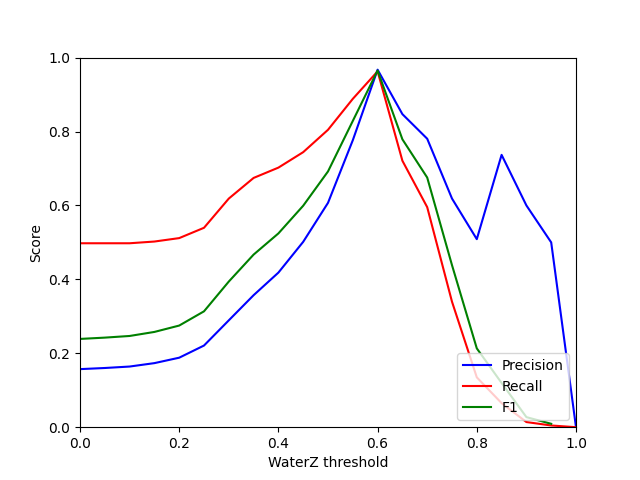

In [87]:
fig = plt.figure()
plt.plot([i['t'] for i in results], [i['precision'] for i in results], 'b', label = 'Precision')
plt.plot([i['t'] for i in results], [i['recall'] for i in results], 'r', label = 'Recall')
plt.plot([i['t'] for i in results], [i['f1'] for i in results], 'g', label = 'F1')

plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Score')
plt.xlabel('WaterZ threshold')
plt.savefig('waterz_optimize_t.png')
plt.show()

In [89]:
from sklearn.metrics import roc_curve, auc

In [90]:
wz_best = get_fragments(image.copy(), 0.6)
pr = precision_recall(groundtruth, wz_best, 0.95)
pr

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 682 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 3273
merging until threshold 0.6
computing initial scores
merging until 0.6
min edge score 0.00328553
threshold exceeded
merged 467 edges
extracting segmentation


(0.9672897196261683,
 0.9627906976744186,
 0.9650349650349651,
 (array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 

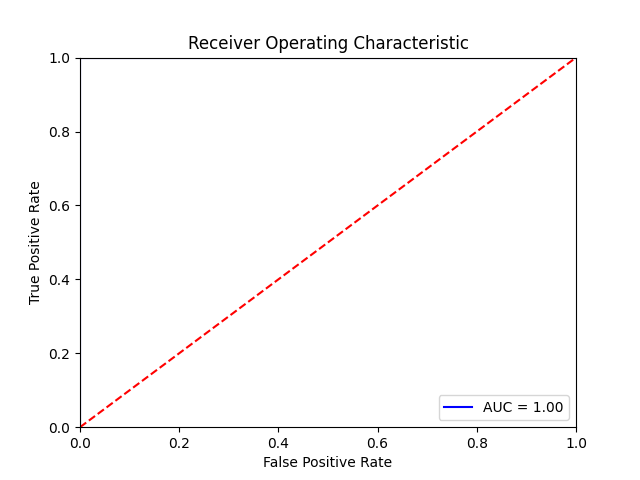

In [548]:
fpr, tpr, thresholds = roc_curve(pr[2][0], pr[2][2])
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
fig = plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [91]:
gt_rp = regionprops(groundtruth)
wz_rp = regionprops(wz_best)

def draw_img(z):
    fig = plt.figure(figsize=(10, 3))
      
    # setting values to rows and column variables
    rows = 1
    columns = 3
    fig.add_subplot(rows, columns, 1)
    
    # Plot segmented boundaries
    plt.imshow(image[z], cmap='viridis')
    plt.axis('off')
    plt.title('Boundaries')

    ## Plot
    ax = fig.add_subplot(rows, columns, 2)
    plt.imshow(groundtruth[z])
    plt.axis('off')
    plt.title('GT')
    
    # Plot
    fig.add_subplot(rows, columns, 3)
    plt.imshow(wz_best[z])
    plt.axis('off')
    plt.title('WaterZ Best')
    
    plt.show()

    return

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

max_z, *_ = image.shape
p=interactive(draw_img, 
              z=widgets.IntSlider(min=0, max=max_z-1, step=1, continuous_update=True, value=0))
display(p)

interactive(children=(IntSlider(value=0, description='z', max=14), Output()), _dom_classes=('widget-interact',…

In [188]:
norm_img = cv2.normalize(image.copy(), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
gt_masks = [mask(groundtruth, i) for i in np.unique(groundtruth)]
pred_masks = [mask(wz_best, i) for i in np.unique(wz_best)]
gt_cells = [norm_img*gt_masks[a] for a,i in enumerate(np.unique(groundtruth))]
pred_cells = [norm_img*pred_masks[a] for a,i in enumerate(np.unique(wz_best))]

def draw_cells(gt_c, pred_c, z):
    fig = plt.figure(figsize=(10, 3))
      
    # setting values to rows and column variables
    rows = 2
    columns = 2
    
    # Plot gt cell
    fig.add_subplot(rows, columns, 1)
    plt.imshow(gt_cells[gt_c][z], cmap='viridis')
    plt.axis('off')
    plt.title('Groundtruth Cell '+str(np.unique(groundtruth)[gt_c]))

    # Plot gt cell hist
    fig.add_subplot(rows, columns, 2)
    c1, b1 = np.histogram(gt_cells[gt_c])
    b1 = b1[1:]; c1 = c1[1:]
    plt.hist(b1[:-1], b1, weights=c1)


    # Plot segmented cell
    fig.add_subplot(rows, columns, 3)
    plt.imshow(pred_cells[pred_c][z], cmap='viridis')
    plt.axis('off')
    plt.title('Predicted Cell '+str(np.unique(wz)[pred_c]))

    # Plot pred cell hist
    fig.add_subplot(rows, columns, 4)
    c2, b2 = np.histogram(pred_cells[pred_c])
    b2 = b2[1:]; c2 = c2[1:]
    plt.hist(b2[:-1], b2, weights=c2)

    print('Dice:',dice_coefficient(gt_masks[gt_c], pred_masks[pred_c]))
    print('IoU:',jaccard_coefficient(gt_masks[gt_c], pred_masks[pred_c]))
    
    plt.show()

    return

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

max_z, *_ = image.shape
max_gt_c = len(np.unique(groundtruth))-1
max_pred_c = len(np.unique(wz_best))-1
p=interactive(draw_cells, 
              gt_c=widgets.IntSlider(min=0, max=max_gt_c, step=1, continuous_update=True, value=0),
              pred_c=widgets.IntSlider(min=0, max=max_pred_c, step=1, continuous_update=True, value=0),
              z=widgets.IntSlider(min=0, max=max_z-1, step=1, continuous_update=True, value=0))
display(p)

interactive(children=(IntSlider(value=0, description='gt_c', max=214), IntSlider(value=0, description='pred_c'…

# Compare with GT fragments

In [49]:
f1.close()

from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import disk, ball
from skimage.segmentation import watershed
from skimage import data
from skimage.feature import peak_local_max

from skimage.filters import rank
from scipy import ndimage as ndi

from skimage.util import img_as_ubyte

In [14]:
def draw_img2(z):
    image2 = img_as_ubyte(image)
    
    distance = ndi.distance_transform_edt(image2)
    coords = peak_local_max(distance, footprint=np.ones((5, 5, 5)), labels=image2)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels2 = watershed(-distance, markers, mask=image2)

    #denoised = rank.median(image2, ball(2))
    #markers = rank.gradient(denoised, ball(1)) < 10
    #gradient = rank.gradient(denoised, ball(1))
    #labels = watershed(gradient, markers)
    
    # display results
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True)
    ax = axes.ravel()
    
    ax[0].imshow(image2[z], cmap=plt.cm.gray)
    ax[0].set_title("Original")
    
    ax[1].imshow(distance[z], cmap=plt.cm.nipy_spectral)
    ax[1].set_title("Dist")
    
    ax[2].imshow(mask[z], cmap=plt.cm.nipy_spectral)
    ax[2].set_title("Mask")
    
    ax[3].imshow(image2[z], cmap=plt.cm.gray)
    ax[3].imshow(labels2[z], cmap=plt.cm.nipy_spectral, alpha=.5)
    ax[3].set_title("Segmented")
    
    for a in ax:
        a.axis('off')
    
    fig.tight_layout()
    plt.show()

    #print(labels.all())

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

p=interactive(draw_img2, 
              z=widgets.IntSlider(min=0, max=max_z-1, step=1, continuous_update=True, value=z))
display(p)

interactive(children=(IntSlider(value=8, description='z', max=14), Output()), _dom_classes=('widget-interact',…

# Visualize small-alice-tracked-loop

In [12]:
import skimage.io as skio

path="./data/fate-predict-datasets/Alice/small-alice-tracked-loop"
file=path+"/plantseg-predictions/C1C2_memZO1_TT_50_predictions.h5"
f1 = h5py.File(file,'r+')

# Get fragments
img = f1['predictions'][0].copy()
pred_fragments = get_fragments(img, 0.6)
f1.close()

# Get gt fragments
gt_fragments = skio.imread(path+'/CellSeg50_rot.ome.tiff', plugin='tifffile')

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 485 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2149
merging until threshold 0.6
computing initial scores
merging until 0.6
min edge score 0.0516804
threshold exceeded
merged 311 edges
extracting segmentation


In [18]:
from imaris_ims_file_reader.ims import ims
a = ims(path+'/AbiLoopMovie_tp1_50_ch_1_2.ims')

Opening readonly file: /Users/daniel/Spaces/Education/00.KU/Thesis/data/fate-predict-datasets/Alice/small-alice-tracked-loop/AbiLoopMovie_tp1_50_ch_1_2.ims 

Closing file: /Users/daniel/Spaces/Education/00.KU/Thesis/data/fate-predict-datasets/Alice/small-alice-tracked-loop/AbiLoopMovie_tp1_50_ch_1_2.ims 



In [34]:
raw = a[49, 0]
raw = np.flip(raw, axis=2)
raw = np.rot90(raw, axes=(1, 2))

c2 = a[49, 1]
c2 = np.flip(c2, axis=2)
c2 = np.rot90(c2, axes=(1, 2))

def draw_img(z):
    fig = plt.figure(figsize=(7, 7))
      
    # setting values to rows and column variables
    rows = 3
    columns = 2
    fig.add_subplot(rows, columns, 1)
    
    # GT
    plt.imshow(gt_fragments[z])
    plt.axis('off')
    plt.title('GT')

    # Pred
    ax = fig.add_subplot(rows, columns, 2)
    plt.imshow(pred_fragments[z])
    plt.axis('off')
    plt.title('Pred')

    # Raw
    ax = fig.add_subplot(rows, columns, 3)
    plt.imshow(raw[z])
    plt.axis('off')
    plt.title('Raw')
    
    # Boundaries
    ax = fig.add_subplot(rows, columns, 4)
    plt.imshow(img[z])
    plt.axis('off')
    plt.title('Boundaries')

    # C2
    ax = fig.add_subplot(rows, columns, 5)
    plt.imshow(c2[z])
    plt.axis('off')
    plt.title('C2')

    
    plt.show()

    return

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

max_z, *_ = pred_fragments.shape
p=interactive(draw_img, 
              z=widgets.IntSlider(min=0, max=max_z-1, step=1, continuous_update=True, value=0))
display(p)

interactive(children=(IntSlider(value=0, description='z', max=43), Output()), _dom_classes=('widget-interact',…

In [17]:
import napari
viewer = napari.Viewer()
viewer.add_image(raw, name='Raw')
viewer.add_image(img, name='Boundaries')
viewer.add_labels(gt_fragments)
viewer.add_labels(pred_fragments)

<Labels layer 'pred_fragments' at 0x2fb0746a0>

In [22]:
out = precision_recall(gt_fragments, pred_fragments, threshold=0.60)

In [30]:
print('WaterZ Precision/Recall/F1:', out[0:3])

WaterZ Precision/Recall/F1: (0.6878612716763006, 0.6761363636363636, 0.681948424068768)


In [58]:
norm_img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
gt_masks = [mask(gt_fragments, i) for i in np.unique(gt_fragments)]
pred_masks = [mask(pred_fragments, i) for i in np.unique(pred_fragments)]
gt_cells = [norm_img*gt_masks[a] for a,i in enumerate(np.unique(gt_fragments))]
pred_cells = [norm_img*pred_masks[a] for a,i in enumerate(np.unique(pred_fragments))]

def draw_cells(gt_c, pred_c, z):
    fig = plt.figure(figsize=(9, 9))
      
    # setting values to rows and column variables
    rows = 2
    columns = 2
    
    # Plot gt cell
    fig.add_subplot(rows, columns, 1)
    plt.imshow(gt_cells[gt_c][z], cmap='viridis')
    plt.axis('off')
    plt.title('Groundtruth Cell '+str(np.unique(gt_fragments)[gt_c]))

    fig.add_subplot(rows, columns, 2)
    plt.imshow(gt_masks[gt_c][z], cmap='viridis')
    plt.axis('off')
    plt.title('Groundtruth Mask '+str(np.unique(gt_fragments)[gt_c]))

    # Plot gt cell hist
    #fig.add_subplot(rows, columns, 2)
    #c1, b1 = np.histogram(gt_cells[gt_c])
    #b1 = b1[1:]; c1 = c1[1:]
    #plt.hist(b1[:-1], b1, weights=c1)


    # Plot segmented cell
    fig.add_subplot(rows, columns, 3)
    plt.imshow(pred_cells[pred_c][z], cmap='viridis')
    plt.axis('off')
    plt.title('Predicted Cell '+str(np.unique(pred_fragments)[pred_c]))

    fig.add_subplot(rows, columns, 4)
    plt.imshow(pred_masks[pred_c][z], cmap='viridis')
    plt.axis('off')
    plt.title('Predicted Mask '+str(np.unique(pred_fragments)[pred_c]))
    
    # Plot pred cell hist
    #fig.add_subplot(rows, columns, 4)
    #c2, b2 = np.histogram(pred_cells[pred_c])
    #b2 = b2[1:]; c2 = c2[1:]
    #plt.hist(b2[:-1], b2, weights=c2)

    print('Dice:',dice_coefficient(gt_masks[gt_c], pred_masks[pred_c]))
    print('IoU:',jaccard_coefficient(gt_masks[gt_c], pred_masks[pred_c]))
    
    plt.show()

    return

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

max_z, *_ = norm_img.shape
max_gt_c = len(np.unique(gt_fragments))-1
max_pred_c = len(np.unique(pred_fragments))-1
p=interactive(draw_cells, 
              gt_c=widgets.IntSlider(min=0, max=max_gt_c, step=1, continuous_update=True, value=0),
              pred_c=widgets.IntSlider(min=0, max=max_pred_c, step=1, continuous_update=True, value=0),
              z=widgets.IntSlider(min=0, max=max_z-1, step=1, continuous_update=True, value=0))
display(p)

interactive(children=(IntSlider(value=0, description='gt_c', max=175), IntSlider(value=0, description='pred_c'…

In [34]:
results = []
for i in np.arange(0, 1.05, 0.05):
    _wz = get_fragments(f1['predictions'][0].copy(), i)
    (precision, recall, f1, (pred_correct, gt_correct, ji)) = precision_recall(gt_fragments, _wz, 0.65)
    tp = np.sum(pred_correct) # Correct predictions
    fp = np.abs(tp-len(pred_correct)) # The incorrectly predicted cells
    fn = np.abs(tp-len(gt_correct))

    results.append({'tp': tp, 'fp': fp, 'fn': fn, 'precision':precision, 'recall': recall, 'f1': f1, 't':i})

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 485 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2149
merging until threshold 0
computing initial scores
merging until 0
min edge score 0.0516804
threshold exceeded
merged 0 edges


KeyboardInterrupt: 

In [ ]:
results